In [1]:
%matplotlib inline

# Background

This starts with a version of the Dipy Tracking Quickstart Tutorial (http://nipy.org/dipy/examples_built/tracking_quick_start.html#example-tracking-quick-start) for beginners to python. We then go through two more advanced methods for working with streamline data: Quickbundles and Recobundles.

We are using an ipython notebook to run tracking because you can view your results with your code step-by-step. The first line (%matplotlib inline) is run to make figures show inline

To run a line of code, click on it and hold down the shift key while you press enter/return

NOTE: We assume that you have eddy-corrected (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy) (and if you can susceptibility-corrected; https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup) your data

For more examples:
http://nipy.org/dipy/examples_built/

# Imports

In [108]:
# os has lots of tools for working with the operating system 
# (mkdir, ls, etc.)
# https://docs.python.org/2/library/os.html
import os

# glob allows you to list paths with wildcards
from glob import glob

# nibabel helps us load and save filetypes in neuroimaging
# http://nipy.org/nibabel/
import nibabel as nib

# nilearn has really nice plotting
import nilearn.plotting as nip

# gradient table will be used to load our bvalues and bvectors
from dipy.data import gradient_table

# this will display snapshots inline so we can see our results
from IPython.display import Image

# length function
from dipy.tracking.utils import length

# imports from the Dipy tracking quickstart tutorial
import numpy as np
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel, color_fa
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram
from dipy.tracking.streamline import Streamlines

Choose whether or not you want interactive windows to pop up, or just snapshots saved. Note: if interactive = True, you need to babysit the notebook until all windows have popped up

In [6]:
interactive = False

# Download our data 
(if we don't have it already)

In [80]:
fetch_stanford_hardi()
#img, gtab = read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/kesshijordan/.dipy/stanford_hardi 


({'HARDI150.bval': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.bvals',
   '4e08ee9e2b1d2ec3fddb68c70ae23c36'),
  'HARDI150.bvec': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.bvecs',
   '4c63a586f29afc6a48a5809524a76cb4'),
  'HARDI150.nii.gz': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.nii.gz',
   '0b18513b46132b4d1051ed3364f2acbc')},
 '/Users/kesshijordan/.dipy/stanford_hardi')

# Find our data

In the other dipy tutorials, you usually use a function like read_stanford_hardi(), but that won't work on your own data so let's look for it ourselves

FOR YOUR DATA: EDIT THIS SECTION TO MAKE SURE YOU GET THE THREE FILES: BVALUE, BVECTOR, AND NIFTI

In [7]:
data_directory = '/Users/kesshijordan/.dipy/stanford_hardi/'

List the contents of the directory (ls)

In [8]:
contents_of_data_directory = os.listdir(data_directory)
contents_of_data_directory

['pve_wm.nii.gz',
 'HARDI150.bvec',
 'HARDI150.bval',
 'label-info.txt',
 'aparc-reduced.nii.gz',
 'HARDI150.nii.gz',
 't1.nii.gz',
 'pve_csf.nii.gz',
 'label_info.txt',
 'pve_gm.nii.gz']

Glob lets us list things that match a given pattern with wildcards (*)

In [9]:
# This pattern lists everything in data directory
contents_of_data_directory = glob(data_directory+'/*')
contents_of_data_directory

['/Users/kesshijordan/.dipy/stanford_hardi/pve_wm.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.bvec',
 '/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.bval',
 '/Users/kesshijordan/.dipy/stanford_hardi/label-info.txt',
 '/Users/kesshijordan/.dipy/stanford_hardi/aparc-reduced.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/t1.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/pve_csf.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/label_info.txt',
 '/Users/kesshijordan/.dipy/stanford_hardi/pve_gm.nii.gz']

In [10]:
# This pattern lists everything that ends in ".nii.gz" in the data directory
nifti_list = glob(data_directory+'/*.nii.gz')
nifti_list

['/Users/kesshijordan/.dipy/stanford_hardi/pve_wm.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/aparc-reduced.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/t1.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/pve_csf.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/pve_gm.nii.gz']

There are several files that match this pattern, so let's be a little more specific

In [12]:
# This pattern lists everything that ends in ".nii.gz" in the data directory
nifti_list = glob(data_directory+'/*.nii.gz')
nifti_list

['/Users/kesshijordan/.dipy/stanford_hardi/pve_wm.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/aparc-reduced.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/t1.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/pve_csf.nii.gz',
 '/Users/kesshijordan/.dipy/stanford_hardi/pve_gm.nii.gz']

In [13]:
# This pattern lists everything that starts with "HARDI" and 
# ends with ".nii.gz" in the data directory
nifti_list = glob(data_directory+'/HARDI*.nii.gz')
nifti_list

['/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.nii.gz']

We can get the path by selecting the first item in the list returned by glob

In [14]:
data_file = nifti_list[0]
data_file

'/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.nii.gz'

In [15]:
bvec_list = glob(data_directory+'/*.bvec')
bvec_list

['/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.bvec']

In [16]:
bvec_file = bvec_list[0]
bvec_file

'/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.bvec'

If there is only one file, you can even do both steps at once. Always check that the file you think you're pulling is the one you actually get 

(e.g. what if someone added another nifti file to your directory? Next time you run the code it could select the wrong file). 

In [18]:
bval_file = glob(data_directory+'/*.bval')[0]
bval_file

'/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.bval'

If we use a consistent filename, we could also substitute instead

In [19]:
bval_file = data_file.replace('.nii.gz','.bval')
bval_file

'/Users/kesshijordan/.dipy/stanford_hardi/HARDI150.bval'

## Load the data

In [20]:
img = nib.load(data_file)
data = img.get_data()

# load the bvectors and bvalues into a gradient table
gtab = gradient_table(bval_file, bvec_file)

Let's check and see if our files match our expectations

In [21]:
print(data.shape)

(81, 106, 76, 160)


our data is 81 x 106 voxel resolution in-plane, 76 slices, and 160 volumes

In [22]:
print(gtab.bvals)

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000.]


... and we have our bvalues... 10 b0 volumes (no diffusion weighting) followed by 150 b2000 volumes

In [23]:
print(gtab.bvecs.shape)

(160, 3)


... and the shape of our bvecs make sense... 160 gradients by 3 dimenstions (xyz)

# Save a B0 image

Pick the first B0 image

In [25]:
index_of_first_B0 = np.where(gtab.b0s_mask)[0][0]
index_of_first_B0

0

Good... we saw from our list that the first volume is a b0 image so this matches our expectation

In [26]:
b0_array = data[:,:,:,index_of_first_B0]
b0_save_path = data_file.replace('.nii.gz','_b0.nii.gz')
save_nifti(b0_save_path, b0_array, img.affine)

we just saved the b0 using the affine from the image (the b0 is in the same space as the overall diffusion image so we can just use the affine from the diffusion dataset)

# Do a quick brain segmentation

Note: the brain segmentation default parameters don't work, so we use specific ones here. On your own data, try the defaults first

In [98]:
maskdata, mask = median_otsu(data, 3, 2, False,
                             vol_idx=range(0, 50))
mask_save_path = data_file.replace('.nii.gz','_mask.nii.gz')
save_nifti(mask_save_path, mask*1, img.affine)

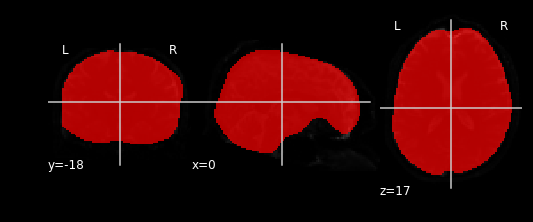

In [99]:
nip.plot_roi(mask_save_path, bg_img=b0_save_path, cmap=nip.cm.bwr_r)

# Estimate response function for CSD

The response function is an estimation based on the data of the signal produced by a single cohoerent bundle of fibers. We will use bundles with very high FA to generate this from our data.

In [100]:
response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

# Let's look at CSD vs. Tensor Model

# Fit the data and calculate fiber directions

In [101]:
sphere = get_sphere('symmetric724')

csd_peaks = peaks_from_model(model=csd_model,
                             data=data,
                             sphere=sphere,
                             mask=mask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

Check out our peaks on an axial slice by running this cell... a window will pop up 

(if you don't see a window pop up, then check if the variable interactive is set to True)

In [128]:
def show_peaks(peaks, out_path='csd_direction_field.png'):
    ren = window.Renderer()
    ren.add(actor.peak_slicer(peaks.peak_dirs,
                              peaks.peak_values,
                              colors=None))

    if interactive:
        window.show(ren, size=(900, 900))
    else:
        window.record(ren, out_path=out_path, size=(900, 900))
    return out_path

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


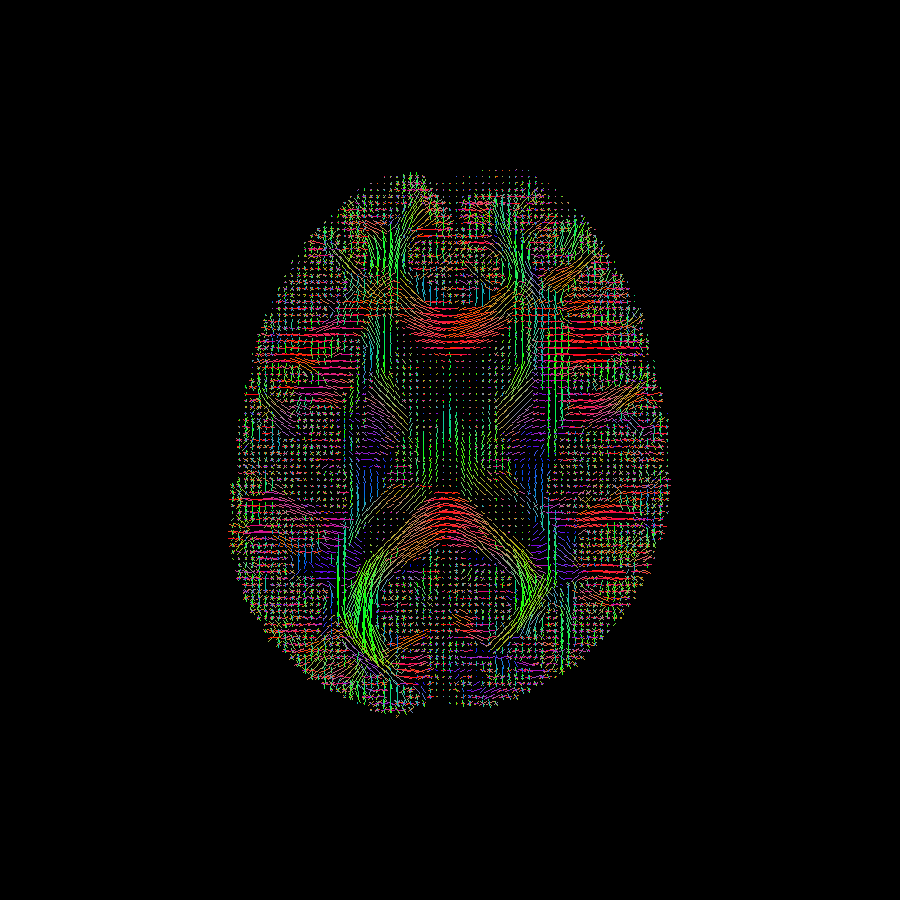

In [129]:
Image(show_peaks(csd_peaks))

# Fit the tensor model for the stopping condition (FA)

In [103]:
tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(data, mask)

In [110]:
fa = tensor_fit.fa

# clip FA values to between 0 and 1
fa = np.clip(fa, 0, 1)

In [130]:
def show_tensors(tenfit, fa, out_path='tensor_ellipsoids.png'):
    ren = window.Renderer()

    rgb = color_fa(fa, tenfit.evecs)
    
    evals = tenfit.evals[13:43, 44:74, 28:29]
    evecs = tenfit.evecs[13:43, 44:74, 28:29]

    cfa = rgb[13:43, 44:74, 28:29]
    cfa /= cfa.max()

    ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, 
                                sphere=sphere, scale=0.3))

    print('Saving illustration as tensor_ellipsoids.png')
    window.record(ren, n_frames=1, out_path=out_path, size=(600, 600))
    if interactive:
        window.show(ren)
    return out_path

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


Saving illustration as tensor_ellipsoids.png


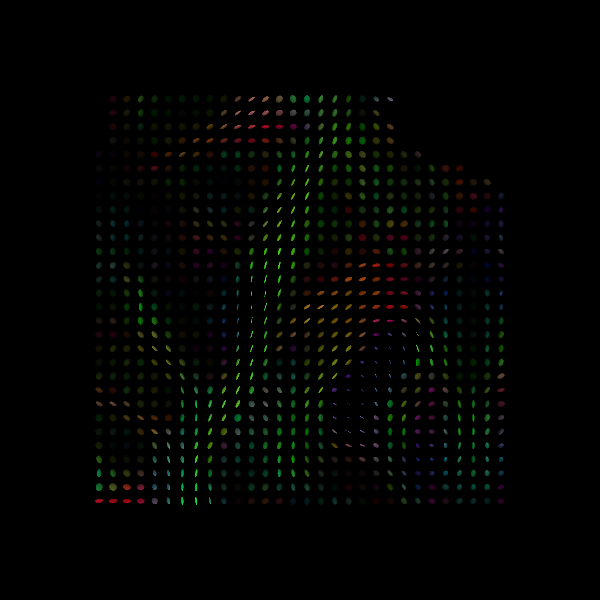

In [131]:
Image(show_tensors(tensor_fit,fa))

# Our tissue classifier (gray/white/csf) uses FA

In [133]:
tissue_classifier = ThresholdTissueClassifier(fa, 0.15)

# Generate seeds to track from in voxels with high FA

Let's seed all of the voxels with FA greater than 0.3 with one seed

In [134]:
seeds = random_seeds_from_mask(fa > 0.3, seeds_count=1)

In [135]:
streamline_generator = LocalTracking(csd_peaks, tissue_classifier,
                                     seeds, affine=np.eye(4),
                                     step_size=0.5)

streamlines = Streamlines(streamline_generator)

Now let's check how many streamlines we generated

In [136]:
print(len(streamlines))

78631


We can take a look at our streamlines now

In [166]:
def show_sls(streamlines, out_path='streamlines.png'):
    ren.clear()
    ren.add(actor.line(streamlines))

    if interactive:
        window.show(ren, size=(900, 900))
    else:
        window.record(ren, out_path=out_path, size=(900, 900))
    return out_path

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


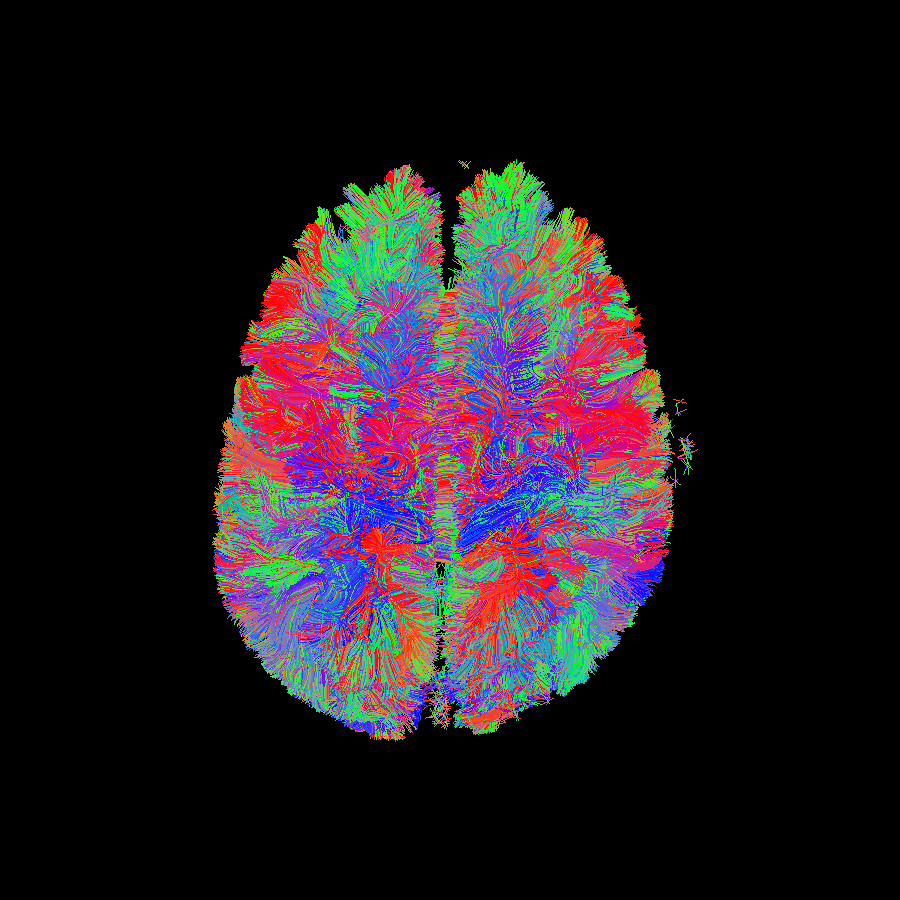

In [167]:
Image(show_sls(streamlines))

Save our wholebrain tractography dataset as a .trk file

In [155]:
#save_trk(Tractogram(streamlines, affine_to_rasmm=img.affine),
#         'det_streamlines.trk')

save_nifti('fa_map.nii.gz', fa, img.affine)

This streamline dataset contains many streamlines that we are not interested in... there is sometimes a shell of short streamlines around the periphery of the brain that we know are an artifact of our tracking procedure... we can remove them with a length threhsold

NOTE: need to convert to mm... this is 2mm isotropic (see affine) so we need to multiply by 2 to get mm. That means 20 units is 40mm so we will set our threshold at 20

nibabel's new streamline handling should fix this, I think?

In [156]:
img.affine

array([[   2.,    0.,    0.,  -80.],
       [   0.,    2.,    0., -120.],
       [   0.,    0.,    2.,  -60.],
       [   0.,    0.,    0.,    1.]])

Text(0,0.5,'Count')

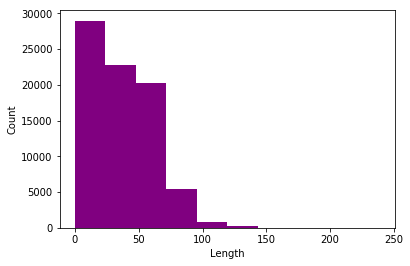

In [157]:
# Calculate the length of each streamline in the dataset
lengths = list(length(streamlines))

import matplotlib.pyplot as plt

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='purple')
ax.set_xlabel('Length')
ax.set_ylabel('Count')

In [158]:
# Set a threshold and create a new variable to store the long streamlines on
length_threshold = 20
long_streamlines = [] # initialize an empty list
for i,sl in enumerate(streamlines):
    if lengths[i] > length_threshold:
        long_streamlines.append(sl)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


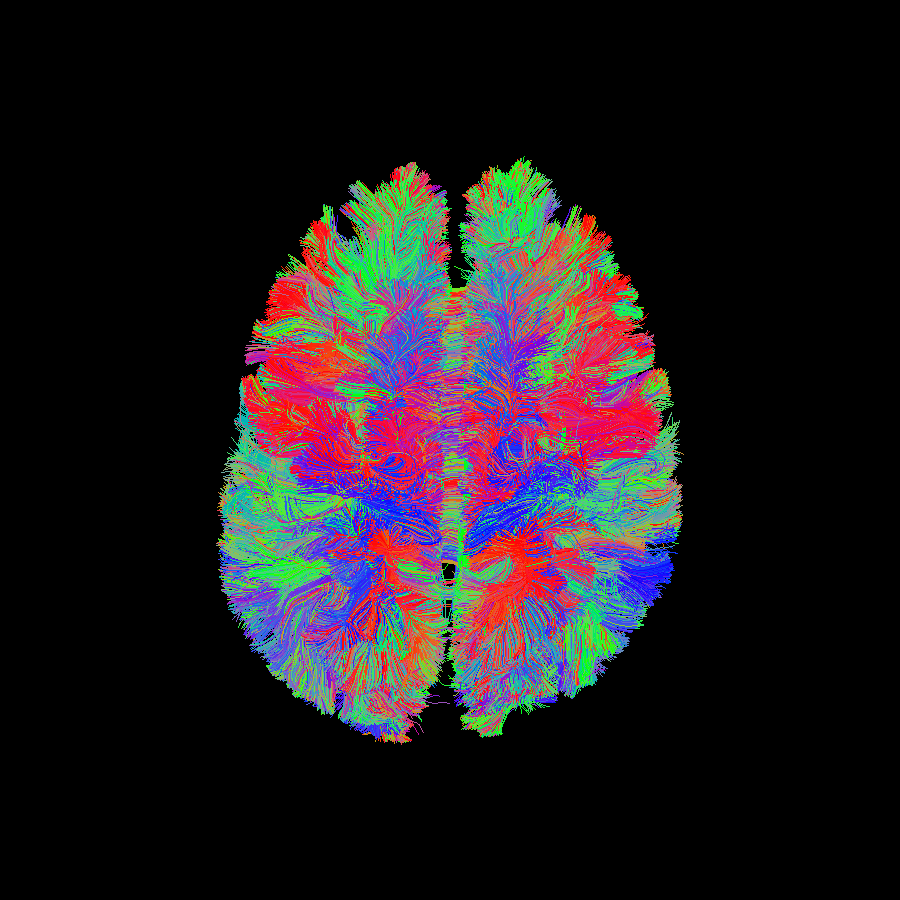

In [168]:
Image(show_sls(long_streamlines))

Save our new track

In [169]:
save_trk(Tractogram(long_streamlines, affine_to_rasmm=img.affine),
         'det_streamlines_long.trk')

# Explore our results with Quickbundles

In [170]:
from dipy.segment.clustering import QuickBundles

In [179]:
qb = QuickBundles(threshold=10.)
clusters = qb.cluster(streamlines)
print(len(clusters), "Clusters")

441 Clusters


Let's take a look at the centroids...

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


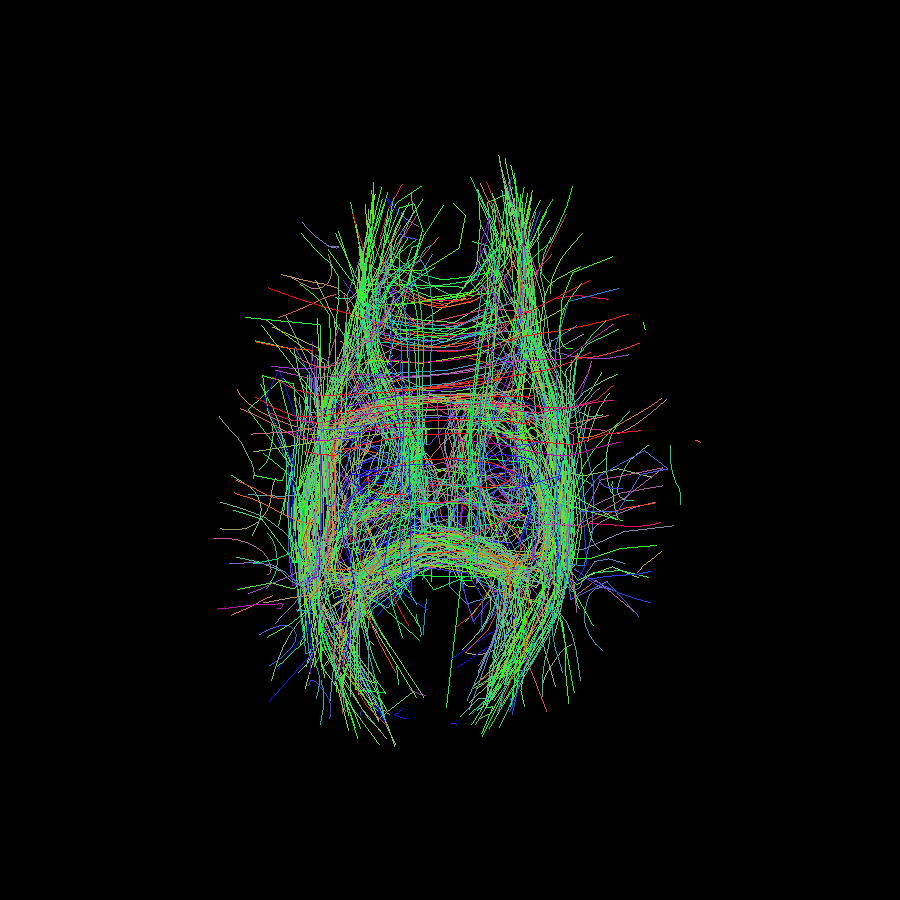

In [195]:
Image(show_sls(clusters.centroids))

Text(0,0.5,'Count')

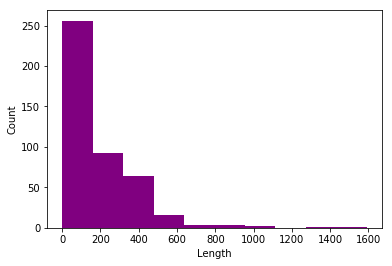

In [185]:
clsz = [len(cl) for cl in clusters]

fig_hist, ax = plt.subplots(1)
ax.hist(clsz, color='purple')
ax.set_xlabel('Length')
ax.set_ylabel('Count')

Let's take a look at our biggest cluster

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


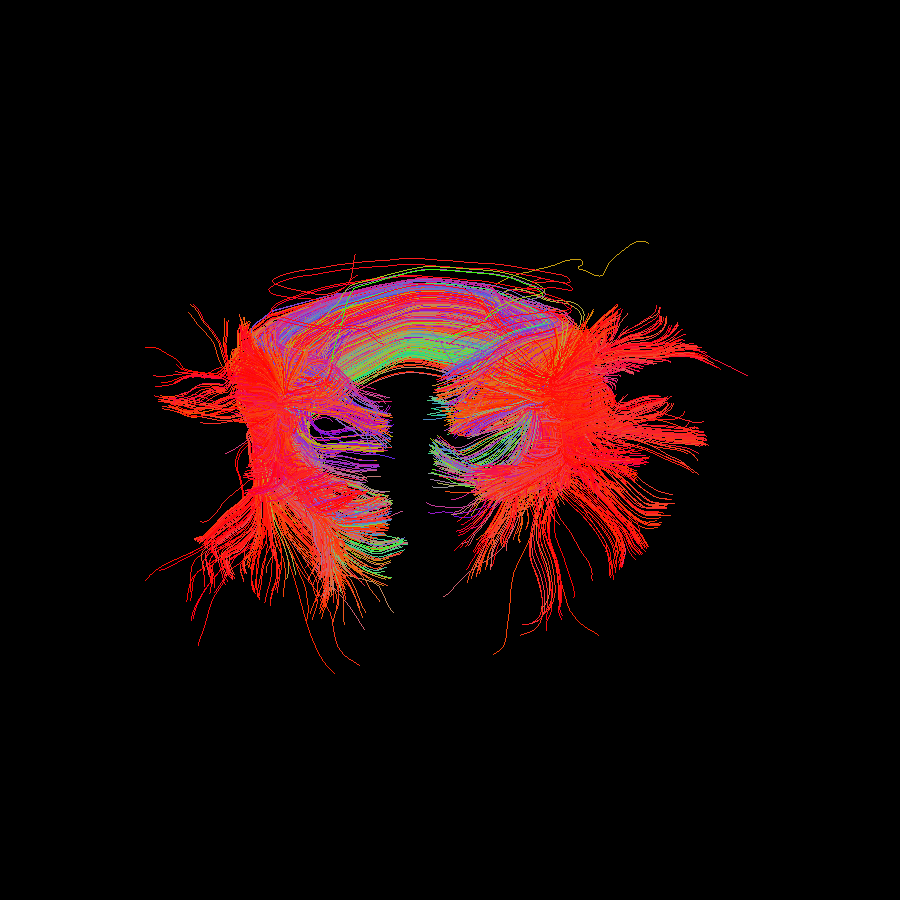

In [196]:
Image(show_sls(clusters[np.argmax(clsz)]))

# Let's try to automatically segment the CST using Recobundles... to do this we need to use the new nibabel streamline API 

In [260]:
from dipy.align.streamlinear import whole_brain_slr, slr_with_qb, transform_streamlines

In [223]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg

WHY DO THESE NEED TO BE ARRAY SEQUENCES?

In [233]:
temp_cst_tg = loadtgm_newapi('/Users/kesshijordan/Desktop/IU_Bloomington/template_frank/MNI_space/CST_L.trk')
temp_cst_sls = temp_cst_tg.streamlines
temp_cst_as = nib.streamlines.array_sequence.ArraySequence(temp_wb_sls)

temp_wb_tg = loadtgm_newapi('/Users/kesshijordan/Desktop/IU_Bloomington/template_frank/whole_brain_MNI.trk')
temp_wb_sls = temp_wb_tg.streamlines
temp_wb_sls_as = nib.streamlines.array_sequence.ArraySequence(temp_wb_sls)

In [228]:
sub_wb_tg = loadtgm_newapi('det_streamlines_long.trk')
sub_wb_sls = sub_wb_tg.streamlines
sub_wb_sls_as = nib.streamlines.array_sequence.ArraySequence(sub_wb_sls)

In [229]:
def rough_reg(sub_fixed, temp_moving):
    #template moves to the subject space
    moved, transform, qb_centroids1, qb_centroids2 = whole_brain_slr(sub_fixed, temp_moving, 
                                                                     verbose=True,
                                                                     progressive=True)
    return moved, transform, qb_centroids1, qb_centroids2

transform the template to the subject space using a rough streamline 
affine

In [230]:
moved_temp2sub, xfm_temp2sub, qbc1_temp2sub, qbc2_temp2sub = rough_reg(sub_wb_sls_as, temp_wb_sls_as)

Static streamlines size 54032
Moving streamlines size 144678


/Users/kesshijordan/anaconda/lib/python3.6/site-packages/nibabel/streamlines/array_sequence.py:23: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  np.issubdtype(obj.dtype, np.bool)))


Static streamlines after length reduction 48278
Moving streamlines after length reduction 123874
 Resampled to 20 points
 Size is 11.050 MB
 Duration of resampling is 0.032 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 48278 random streamlines
 Duration 1.657 sec. 

 Resampled to 20 points
 Size is 28.353 MB
 Duration of resampling is 0.094 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 123874 random streamlines
 Duration 3.275 sec. 

Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 190
QB moving centroids size 120
SLR finished in  4.656 seconds.
SLR iterations: 42 


In [245]:
def genren(sls, sls2=None, niidata=None, roi1=None, roi2=None, rotx=-90, rotz=90, aff=None, putpath=None, show=False, orient=True, colors=[(1,1,1)]):
    
    renderer = window.Renderer()
    
    if len(colors)>1:
        stream_actor = actor.line(sls, colors=colors[1])
    else:
        stream_actor=actor.line(sls)
    stream_actor.RotateX(rotx)
    stream_actor.RotateZ(rotz)
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=colors[0])
        stream_actor2.RotateX(rotx)
        stream_actor2.RotateZ(rotz)
        renderer.add(stream_actor2)
    
    if roi1 is not None and roi2 is not None:
        
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
        renderer.add(contour_actor2)
        
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)

    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #                    focal_point=(113.30, 128.31, 76.56),
    #                    view_up=(0.18, 0.00, 0.98))

    if orient:
        axes_actor = actor.axes(scale=(10, 10, 10), colorx=(1, 0, 0), colory=(0, 1, 0), colorz=(0, 0, 1), opacity=1)
        #Create an actor with the coordinate’s system axes where red = x, green = y, blue = z.
        renderer.add(axes_actor)

    if show:
        window.show(renderer, size=(600, 600), reset_camera=False)
    if putpath is not None:
        window.record(renderer, out_path=putpath, size=(600, 600))
    del renderer
    return putpath

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


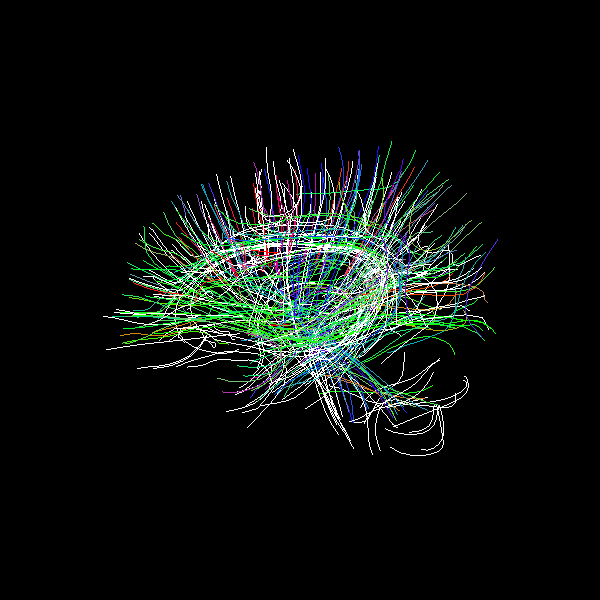

In [246]:
Image(genren(qbc1_temp2sub, qbc2_temp2sub, show=False, putpath='roughreg.png'))

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


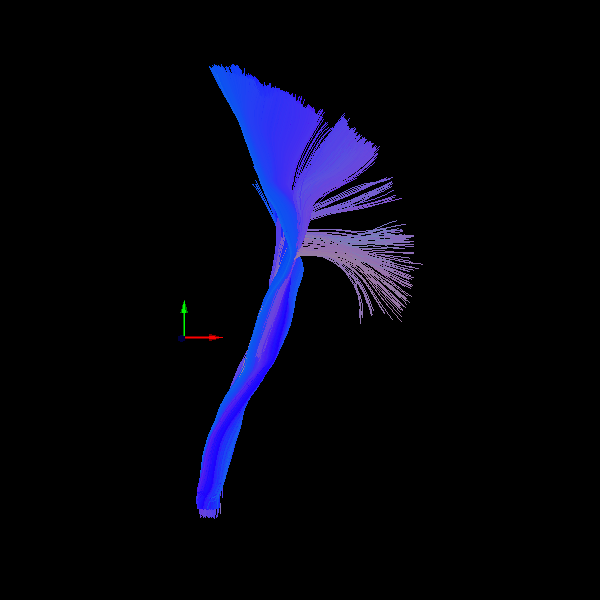

In [249]:
Image(genren(temp_cst_sls, putpath='cst.png', rotz=180))

Transform the CST template into the subject space using our precomputed affine

In [250]:
temp_cst_sls_subspace = temp_cst_tg.copy().apply_affine(xfm_temp2sub).streamlines

Before applying registration

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


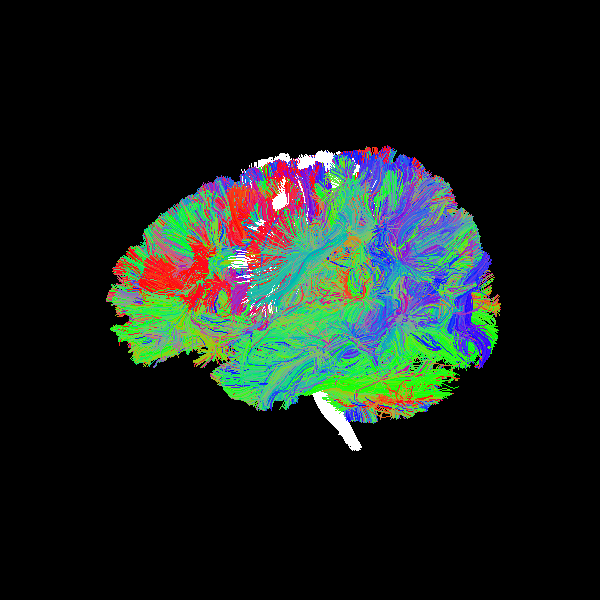

In [254]:
Image(genren(sub_wb_sls, temp_cst_sls, putpath='pre.png'))

After applying registration

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


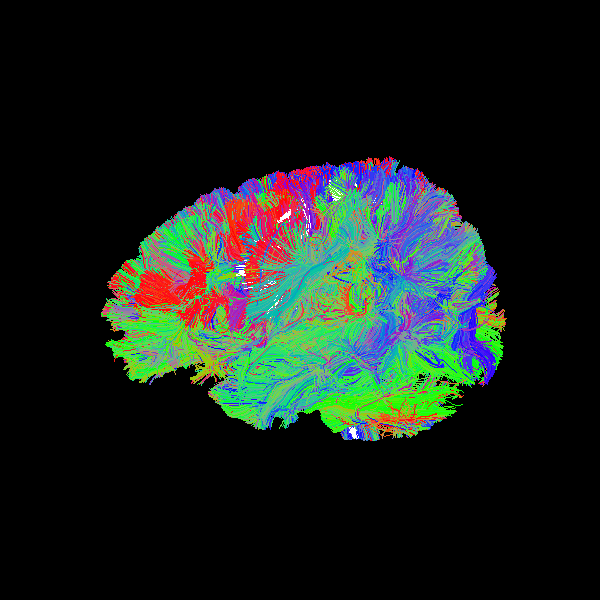

In [255]:
Image(genren(sub_wb_sls, temp_cst_sls_subspace, putpath='post.png'))

In [266]:
from dipy.segment.bundles import RecoBundles
from dipy.segment.clustering import qbx_and_merge

def run_rb(templatesls, bucketosls, cluster_map=None, pruning_thr=10):
    # try pruning thresh 10 if not specific drop to 5
    if cluster_map is None:
        cluster_map = qbx_and_merge(bucketosls, thresholds=[40, 25, 20, 10])
    else:
        print("Loading provided cluster map")

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=5)
    recognized_atlassp, rec_labels, recognized_ptsp = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10, pruning_thr=pruning_thr)
    '''rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=1.)'''
    #D = bundles_distances_mam(templatesls, recognized)
    
    return recognized_ptsp, cluster_map

In [267]:
rb_CST_L, cluster_map = run_rb(temp_cst_sls_subspace, sub_wb_sls)

 Resampled to 20 points
 Size is 12.367 MB
 Duration of resampling is 0.082 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 54032 random streamlines
 Duration 2.806 sec. 

 Streamlines have 1923 centroids
 Total loading duration 0.001 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 2528 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.579 MB
 Duration of resampling is 0.008 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.042 sec. 

 Model bundle has 8 centroids
 Duration 0.051 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 756
 Duration 0.023 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 5.104
 Number of iterations 62
 Matrix size (4, 4)
[[ 0.929  0.047 -0.047  0.688]
 [-0.046  0.93   0.025 -0.829]
 [ 0.048 -0.023  0.93

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


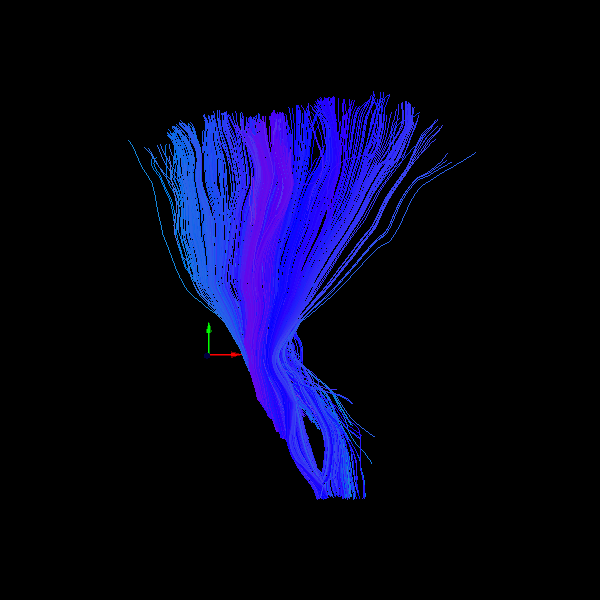

In [268]:
Image(genren(rb_CST_L, putpath='recobundles.png'))